In [1]:
from non_local_detector.simulate.clusterless_simulation import make_simulated_run_data


(
    time,
    position,
    sampling_frequency,
    multiunits,
    multiunits_spikes,
) = make_simulated_run_data()

Cupy is not installed or GPU is not detected. Ignore this message if not using GPU
/home/edeno/miniconda3/envs/non_local_detector_gpu/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
from replay_trajectory_classification.clusterless_simulation import (
    make_fragmented_continuous_fragmented_replay,
)

replay_time, test_multiunits = make_fragmented_continuous_fragmented_replay()

In [3]:
from replay_trajectory_classification import (
    ClusterlessClassifier,
    Environment,
    RandomWalk,
    Uniform,
    estimate_movement_var,
)
import numpy as np


movement_var = estimate_movement_var(position, sampling_frequency)

environment = Environment(place_bin_size=np.sqrt(movement_var))
continuous_transition_types = [
    [RandomWalk(movement_var=movement_var * 120), Uniform()],
    [Uniform(), Uniform()],
]
clusterless_algorithm = "multiunit_likelihood"
clusterless_algorithm_params = {
    "mark_std": 1.0,
    "position_std": 12.5,
}
state_names = ["Continuous", "Fragmented"]
classifier = ClusterlessClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    clusterless_algorithm=clusterless_algorithm,
    clusterless_algorithm_params=clusterless_algorithm_params,
)
classifier.fit(position, multiunits)
results = classifier.predict(test_multiunits, time=replay_time, state_names=state_names)

n_electrodes:   0%|          | 0/5 [00:00<?, ?it/s]

/home/edeno/miniconda3/envs/non_local_detector_gpu/lib/python3.10/site-packages/replay_trajectory_classification/core.py:205: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'F', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  discrete_state_transition[state_k, state_k_1]


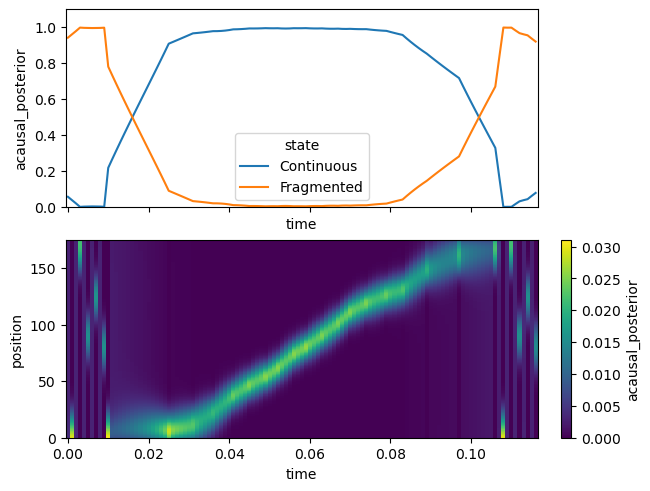

In [4]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 1, sharex=True, constrained_layout=True)
results.acausal_posterior.sum("position").plot(x="time", hue="state", ax=axes[0])
axes[0].set_ylim((0, 1.1))
results.acausal_posterior.sum("state").plot(x="time", y="position", ax=axes[1])

In [5]:
from non_local_detector import ContFragClusterlessClassifier

clusterless_algorithm = "clusterless_kde"
clusterless_algorithm_params = {
    "waveform_std": 1.0,
    "position_std": 12.5,
}

classifier2 = ContFragClusterlessClassifier(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    clusterless_algorithm=clusterless_algorithm,
    clusterless_algorithm_params=clusterless_algorithm_params,
).fit(position, multiunits)
results2 = classifier2.predict(test_multiunits, time=replay_time)

2023-06-26 16:01:37.427702: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 0 and 9; status: INTERNAL: failed to enable peer access from 0x7fc3fc624e40 to 0x7fc40c65c700: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2023-06-26 16:01:37.429601: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 1 and 9; status: INTERNAL: failed to enable peer access from 0x7fc3f879b030 to 0x7fc40c65c700: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2023-06-26 16:01:37.431170: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 2 and 9; status: INTERNAL: failed to enable peer access from 0x7fc400594b30 to 0x7fc40c65c700: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2023-06-26 16:01:37.432509: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 3 and 9; status: INTERNAL: failed to enable peer access from 0x7fc3

Non-Local Likelihood:   0%|          | 0/5 [00:00<?, ?electrode/s]

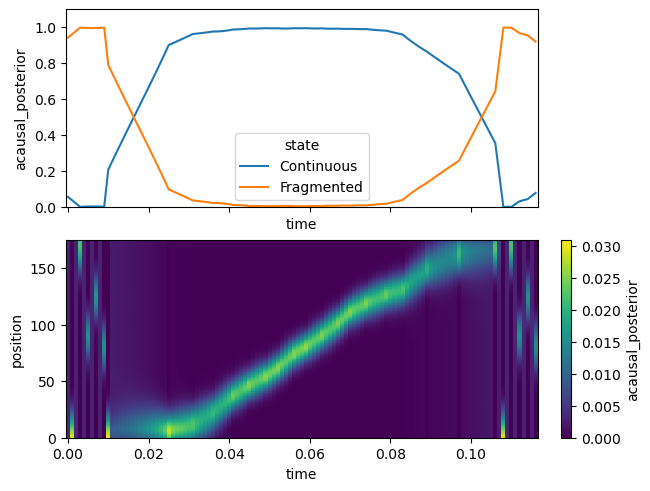

In [6]:
fig, axes = plt.subplots(2, 1, sharex=True, constrained_layout=True)
results2.acausal_posterior.unstack("state_bins").sum("position").plot(
    x="time", hue="state", ax=axes[0]
)
axes[0].set_ylim((0, 1.1))
results2.acausal_posterior.unstack("state_bins").sum("state").plot(
    x="time", y="position", ax=axes[1]
)